In [1]:
# Essential Libraries
import os
import sys
import numpy as np
from numpy import ndarray
import pandas as pd
import datetime
import random
from typing import Callable, Dict, Tuple, List

# ML
from sklearn import datasets
# import tensorflow as tf
# import keras

# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('seaborn-whitegrid')

# Display options
pd.set_option('display.max_columns', None);
pd.options.display.max_seq_items = 8000;
pd.options.display.max_rows = 8000;
%precision 6

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore")

# Define data and image directory
PROJECT_ROOT_DIR = "."
DATA_DIR = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGE_DIR = os.path.join(PROJECT_ROOT_DIR, "img")

from IPython.display import Image
for d in [DATA_DIR, IMAGE_DIR]:
    if not os.path.exists(d):
        os.mkdir(d)

# Define a function to save images
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from pprint import pprint

# This is a little recursive helper function converts all nested ndarrays to python list of lists so that pretty printer knows what to do.

def arrayToList(arr):
    if type(arr) == type(np.array):
        #If the passed type is an ndarray then convert it to a list and
        #recursively convert all nested types
        return arrayToList(arr.tolist())
    else:
        #if item isn't an ndarray leave it as is.
        return arr
    
# Suppress exponential notation, define an appropriate float formatter
# Specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:12.4f}'.format}, linewidth=80)

In [2]:
from numpy import ndarray
from typing import List

def assert_same_shape(array: ndarray,
                      array_grad: ndarray):
    assert array.shape == array_grad.shape, \
        '''
        Two ndarrays should have the same shape;
        instead, first ndarray's shape is {0}
        and second ndarray's shape is {1}.
        '''.format(tuple(array_grad.shape), tuple(array.shape))
    return None

In [3]:
class Operation(object):
    '''
    Base class for an "operation" in a neural network.
    '''
    def __init__(self):
        pass

    def forward(self, input_: ndarray):
        '''
        Stores input in the self._input instance variable
        Calls the self._output() function.
        '''
        self.input_ = input_

        self.output = self._output()

        return self.output


    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Calls the self._input_grad() function.
        Checks that the appropriate shapes match.
        '''
        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        return self.input_grad


    def _output(self) -> ndarray:
        '''
        The _output method must be defined for each Operation
        '''
        raise NotImplementedError()


    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        The _input_grad method must be defined for each Operation
        '''
        raise NotImplementedError()

In [4]:
class ParamOperation(Operation):
    '''
    An Operation with parameters.
    '''

    def __init__(self, param: ndarray) -> ndarray:
        '''
        The ParamOperation method
        '''
        super().__init__()
        self.param = param

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Calls self._input_grad and self._param_grad.
        Checks appropriate shapes.
        '''

        assert_same_shape(self.output, output_grad)

        self.input_grad = self._input_grad(output_grad)
        self.param_grad = self._param_grad(output_grad)

        assert_same_shape(self.input_, self.input_grad)
        assert_same_shape(self.param, self.param_grad)

        return self.input_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Every subclass of ParamOperation must implement _param_grad.
        '''
        raise NotImplementedError()

In [5]:
def normalize(a: np.ndarray):
    other = 1 - a
    return np.concatenate([a, other], axis=1)

def unnormalize(a: np.ndarray):
    return a[np.newaxis, 0]

In [6]:
from scipy.special import logsumexp

def softmax(x, axis=None):
    return np.exp(x - logsumexp(x, axis=axis, keepdims=True))

## Specific `Operation`s

In [7]:
class WeightMultiply(ParamOperation):
    '''
    Weight multiplication operation for a neural network.
    '''

    def __init__(self, W: ndarray):
        '''
        Initialize Operation with self.param = W.
        '''
        super().__init__(W)

    def _output(self) -> ndarray:
        '''
        Compute output.
        '''
        return np.dot(self.input_, self.param)

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute input gradient.
        '''
        return np.dot(output_grad, np.transpose(self.param, (1, 0)))

    def _param_grad(self, output_grad: ndarray)  -> ndarray:
        '''
        Compute parameter gradient.
        '''        
        return np.dot(np.transpose(self.input_, (1, 0)), output_grad)

In [8]:
class BiasAdd(ParamOperation):
    '''
    Compute bias addition.
    '''

    def __init__(self,
                 B: ndarray):
        '''
        Initialize Operation with self.param = B.
        Check appropriate shape.
        '''
        assert B.shape[0] == 1
        
        super().__init__(B)

    def _output(self) -> ndarray:
        '''
        Compute output.
        '''
        return self.input_ + self.param

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute input gradient.
        '''
        return np.ones_like(self.input_) * output_grad

    def _param_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute parameter gradient.
        '''
        param_grad = np.ones_like(self.param) * output_grad
        return np.sum(param_grad, axis=0).reshape(1, param_grad.shape[1])

In [9]:
class Sigmoid(Operation):
    '''
    Sigmoid activation function.
    '''

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> ndarray:
        '''
        Compute output.
        '''
        return 1.0/(1.0+np.exp(-1.0 * self.input_))

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''
        Compute input gradient.
        '''
        sigmoid_backward = self.output * (1.0 - self.output)
        input_grad = sigmoid_backward * output_grad
        return input_grad

In [10]:
class Linear(Operation):
    '''
    "Identity" activation function
    '''

    def __init__(self) -> None:
        '''Pass'''        
        super().__init__()

    def _output(self) -> ndarray:
        '''Pass through'''
        return self.input_

    def _input_grad(self, output_grad: ndarray) -> ndarray:
        '''Pass through'''
        return output_grad

## Loss and MeanSquaredError

In [11]:
class Loss(object):
    '''
    The "loss" of a neural network
    '''

    def __init__(self):
        '''Pass'''
        pass

    def forward(self, prediction: ndarray, target: ndarray) -> float:
        '''
        Computes the actual loss value
        '''
        assert_same_shape(prediction, target)

        self.prediction = prediction
        self.target = target

        loss_value = self._output()

        return loss_value

    def backward(self) -> ndarray:
        '''
        Computes gradient of the loss value with respect to the input to the loss function
        '''
        self.input_grad = self._input_grad()

        assert_same_shape(self.prediction, self.input_grad)

        return self.input_grad

    def _output(self) -> float:
        '''
        Every subclass of "Loss" must implement the _output function.
        '''
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        '''
        Every subclass of "Loss" must implement the _input_grad function.
        '''
        raise NotImplementedError()

class MeanSquaredError(Loss):

    def __init__(self) -> None:
        '''Pass'''
        super().__init__()

    def _output(self) -> float:
        '''
        Computes the per-observation squared error loss
        '''
        loss = (
            np.sum(np.power(self.prediction - self.target, 2)) / 
            self.prediction.shape[0]
        )

        return loss

    def _input_grad(self) -> ndarray:
        '''
        Computes the loss gradient with respect to the input for MSE loss
        '''        

        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]

In [12]:
class SoftmaxCrossEntropy(Loss):
    def __init__(self, eps: float=1e-9) -> None:
        super().__init__()
        self.eps = eps
        self.single_class = False

    def _output(self) -> float:

        # if the network is just outputting probabilities
        # of just belonging to one class:
        if self.target.shape[1] == 0:
            self.single_class = True

        # if "single_class", apply the "normalize" operation defined above:
        if self.single_class:
            self.prediction, self.target = \
            normalize(self.prediction), normalize(self.target)

        # applying the softmax function to each row (observation)
        softmax_preds = softmax(self.prediction, axis=1)

        # clipping the softmax output to prevent numeric instability
        self.softmax_preds = np.clip(softmax_preds, self.eps, 1 - self.eps)

        # actual loss computation
        softmax_cross_entropy_loss = (
            -1.0 * self.target * np.log(self.softmax_preds) - \
                (1.0 - self.target) * np.log(1 - self.softmax_preds)
        )

        return np.sum(softmax_cross_entropy_loss) / self.prediction.shape[0]

    def _input_grad(self) -> ndarray:

        # if "single_class", "un-normalize" probabilities before returning gradient:
        if self.single_class:
            return unnormalize(self.softmax_preds - self.target)
        else:
            return (self.softmax_preds - self.target) / self.prediction.shape[0]

## Creating the Regressor object: Our initial 'Layer'

In [13]:
class Regressor(object):

    def __init__(self,
                 loss: Loss,
                 activation: Operation = Sigmoid(),
                 seed: int =1):
        '''
        The number of "neurons" roughly corresponds to the "breadth" of the layer
        '''
        self.first = True
        self.activation = activation
        self.loss = loss
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []
        self.seed = seed
        if seed:
            setattr(self, "seed", self.seed)

    def _setup_layer(self, input_: ndarray) -> None:
        '''
        The _setup_layer function must be implemented for each layer
        '''
        
        if self.seed:
            np.random.seed(self.seed)

        self.params = []

        # weights
        self.params.append(np.random.randn(input_.shape[1], 1)) # Weight initialization

        # bias
        self.params.append(np.random.randn(1, 1))

        self.operations = [WeightMultiply(self.params[0]),
                           BiasAdd(self.params[1]),
                           self.activation]

        return None

    def forward(self, input_: ndarray) -> ndarray:
        '''
        Passes input forward through a series of operations
        ''' 
        if self.first:
            self._setup_layer(input_)
            self.first = False

        self.input_ = input_

        for operation in self.operations:

            input_ = operation.forward(input_)

        self.output = input_

        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Passes output_grad backward through a series of operations
        Checks appropriate shapes
        '''

        assert_same_shape(self.output, output_grad)

        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)

        input_grad = output_grad
        
        self._param_grads()

        return input_grad

    def _param_grads(self) -> ndarray:
        '''
        Extracts the _param_grads from a layer's operations
        '''

        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:
        '''
        Extracts the _params from a layer's operations
        '''

        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)
                
    def train_batch(self,
                    x_batch: ndarray,
                    y_batch: ndarray) -> float:
        '''
        Passes data forward through the layers.
        Computes the loss.
        Passes data backward through the layers.
        '''
        
        predictions = self.forward(x_batch)

        loss = self.loss.forward(predictions, y_batch)

        self.backward(self.loss.backward())

        return loss
    
    def params(self):
        '''
        Gets the parameters for the Regressor.
        '''
        yield from self.params

    def param_grads(self):
        '''
        Gets the gradient of the loss with respect to the parameters for the Regressor.
        '''
        yield from self.param_grads    

# `Optimizer` and `SGD`

In [14]:
class Optimizer(object):
    '''
    Base class for a neural network optimizer.
    '''
    def __init__(self,
                 lr: float = 0.01):
        '''
        Every optimizer must have an initial learning rate.
        '''
        self.lr = lr

    def step(self) -> None:
        '''
        Every optimizer must implement the "step" function.
        '''
        pass

In [15]:
class SGD(Optimizer):
    '''
    Stochasitc gradient descent optimizer.
    '''    
    def __init__(self,
                 lr: float = 0.01) -> None:
        '''Pass'''
        super().__init__(lr)

    def step(self):
        '''
        For each parameter, adjust in the appropriate direction, with the magnitude of the adjustment 
        based on the learning rate.
        '''
        for (param, param_grad) in zip(self.model.params,
                                       self.model.param_grads):

            param -= self.lr * param_grad

# Creating the Model with Regressor and Optimizer

In [16]:
from copy import deepcopy
from typing import Tuple

class LogisticRegressor(object):
    '''
    Trains a neural network
    '''
    def __init__(self,
                 model: Regressor,
                 optim: Optimizer) -> None:
        '''
        Requires a neural network and an optimizer in order for training to occur. 
        Assign the neural network as an instance variable to the optimizer.
        '''
        
        self.model = model
        self.optim = optim
        self.best_loss = 1e10
        setattr(self.optim, 'model', self.model)
        self.train_losses = []
        self.validation_losses = []
        
        
    def generate_batches(self,
                         X: ndarray,
                         y: ndarray,
                         size: int = 16) -> Tuple[ndarray]:
        '''
        Generates batches for training 
        '''
        assert X.shape[0] == y.shape[0], \
        '''
        features and target must have the same number of rows, instead
        features has {0} and target has {1}
        '''.format(X.shape[0], y.shape[0])

        N = X.shape[0]

        for ii in range(0, N, size):
            X_batch, y_batch = X[ii:ii+size], y[ii:ii+size]

            yield X_batch, y_batch

            
    def fit(self, X_train: ndarray, y_train: ndarray,
            X_test: ndarray, y_test: ndarray,
            epochs: int=100,
            eval_every: int=10,
            batch_size: int=32,
            seed: int = 1,
            restart: bool = True)-> None:
        '''
        Fits the neural network on the training data for a certain number of epochs.
        Every "eval_every" epochs, it evaluated the neural network on the testing data.
        '''

        np.random.seed(seed)
        if restart:
            self.model.first = True

            self.best_loss = 1e10

        for e in range(epochs):

            if (e+1) % eval_every == 0:
                
                # for early stopping
                last_model = deepcopy(self.model)

#             X_train, y_train = permute_data(X_train, y_train)

            batch_generator = self.generate_batches(X_train, y_train,
                                                    batch_size)

            for ii, (X_batch, y_batch) in enumerate(batch_generator):

                self.model.train_batch(X_batch, y_batch)

                self.optim.step()
                
                self.train_losses.append(self.model.train_batch(X_batch, y_batch))
                
                
            if (e+1) % eval_every == 0:

                test_preds = self.model.forward(X_test)
                loss = self.model.loss.forward(test_preds, y_test)
                self.validation_losses.append(loss)

                if loss < self.best_loss:
                    print(f"Validation loss after {e+1} epochs is {loss:.3f}")
                    self.best_loss = loss
                    self.validation_losses.append(self.best_loss)
                    
                else:
                    print(f"""Loss increased after epoch {e+1}, 
                            final loss was {self.best_loss:.3f}, using the model from epoch {e+1-eval_every}""")
                    self.model = last_model
                    # ensure self.optim is still updating self.net
                    setattr(self.optim, 'net', self.model)
                    break
                    
    def predict_proba(self, X)-> ndarray:
        preds = self.model.forward(X)
        preds = preds.reshape(-1, 1)
        
        return preds
    
    def predict(self, X)-> ndarray:
        preds = self.model.forward(X)
        preds = preds.reshape(-1, 1)
        
        y_pred = np.zeros((preds.shape[0], 1))
        
        for i in range(preds.shape[0]):
            y_pred[i, 0] = 1 if preds[i, 0]>0.5 else 0
            
        assert(y_pred.shape == preds.shape)
        
        return y_pred

In [17]:
model = Regressor(
                 activation=Sigmoid(),
                 loss=SoftmaxCrossEntropy(),
                 seed = 1)

### Read in the data, train-test split etc.

In [18]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
features = breast_cancer.feature_names

In [19]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [20]:
def to_2d_np(a: ndarray, 
          type: str="col") -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    '''

    assert a.ndim == 1, \
    "Input tensors must be 1 dimensional"
    
    if type == "col":        
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

## Train the model

In [22]:
# helper function

def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [23]:
log_reg = LogisticRegressor(model, SGD(lr=0.05))

log_reg.fit(X_train, y_train, X_test, y_test,
       epochs = 1000,
       eval_every = 100)

Validation loss after 100 epochs is 7.635
Loss increased after epoch 200, 
                            final loss was 7.635, using the model from epoch 100


In [24]:
predictions = log_reg.predict(X_test)

In [25]:
predictions.shape

(114, 1)

In [26]:
print('accuracy -> {}'.format(sum(predictions == y_test) / y_test.shape[0]))

accuracy -> [      0.8070]


In [27]:
def evaluate_classifier(clf, X_test):
    
    total: int = len(clf.predict(X_test))
    thresh: float = 0.5
    true_positives: int = 0
    true_negatives: int = 0
    false_positives: int = 0
    false_negatives: int = 0
        
    y_pred = clf.predict(X_test)
    
    for i in range(y_pred.shape[0]):
        if y_test[i,0] == 1 and y_pred[i,0] == 1:
            true_positives += 1
        elif y_test[i,0] == 0 and y_pred[i,0] == 0:
            true_negatives += 1
        elif y_test[i,0] == 1 and y_pred[i,0] == 0:
            false_negatives += 1
        elif y_test[i,0] == 0 and y_pred[i,0] == 1:
            false_positives += 1
        
    print(f'True Positives: {true_positives}')
    print(f'True Negatives: {true_negatives}')
    print(f'False Positives: {false_positives}')
    print(f'False Negatives: {false_negatives}')
    print(f'Accuracy: {(true_positives + true_negatives) / total}')
    print(f'Error rate: {(false_positives + false_negatives) / total}')

In [28]:
evaluate_classifier(log_reg, X_test)

True Positives: 51
True Negatives: 41
False Positives: 1
False Negatives: 21
Accuracy: 0.8070175438596491
Error rate: 0.19298245614035087


In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = log_reg.predict(X_test)
target_names = ['class 0', 'class 1']

print('Confusion matrix:')
print(confusion_matrix(y_true, y_pred))
print()
print('Classification report:')
print(classification_report(y_true, y_pred, target_names=target_names))

Confusion matrix:
[[41  1]
 [21 51]]

Classification report:
              precision    recall  f1-score   support

     class 0       0.66      0.98      0.79        42
     class 1       0.98      0.71      0.82        72

    accuracy                           0.81       114
   macro avg       0.82      0.84      0.81       114
weighted avg       0.86      0.81      0.81       114



## Trying our Logistic Regressor on Digits Dataset

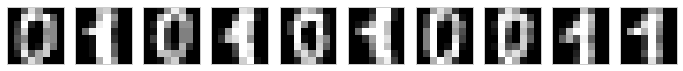

In [30]:
digits,target = datasets.load_digits(n_class=2,return_X_y=True)
fig,ax = plt.subplots(nrows=1, ncols=10,figsize=(12,4),subplot_kw=dict(xticks=[], yticks=[]))

# Plot some images of digits
for i in np.arange(10):
    ax[i].imshow(digits[i,:].reshape(8,8), cmap=plt.cm.gray)   
plt.show()

In [31]:
# Scaling the data
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(digits)
data.shape

(360, 64)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)

# make target 2d array
y_train, y_test = to_2d_np(y_train), to_2d_np(y_test)

In [33]:
model = Regressor(
                 activation=Sigmoid(),
                 loss=SoftmaxCrossEntropy(),
                 seed = 1)

In [34]:
log_reg = LogisticRegressor(model, SGD(lr=0.05))

log_reg.fit(X_train, y_train, X_test, y_test,
       epochs = 1000,
       eval_every = 100)

Validation loss after 100 epochs is 10.074
Loss increased after epoch 200, 
                            final loss was 10.074, using the model from epoch 100


In [35]:
predictions = log_reg.predict(X_test)
predictions.shape

(72, 1)

In [36]:
print('accuracy -> {}'.format(sum(predictions == y_test) / y_test.shape[0]))

accuracy -> [      0.9444]


In [37]:
y_scores = log_reg.predict_proba(X_test)

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = log_reg.predict(X_test)
target_names = ['class 0', 'class 1']

print('Confusion matrix:')
print(confusion_matrix(y_true, y_pred))
print()
print('Classification report:')
print(classification_report(y_true, y_pred, target_names=target_names))

Confusion matrix:
[[33  2]
 [ 2 35]]

Classification report:
              precision    recall  f1-score   support

     class 0       0.94      0.94      0.94        35
     class 1       0.95      0.95      0.95        37

    accuracy                           0.94        72
   macro avg       0.94      0.94      0.94        72
weighted avg       0.94      0.94      0.94        72



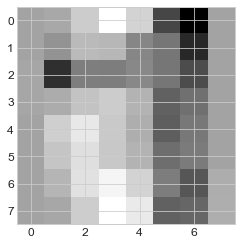

In [40]:
plt.imshow(X_test[1].reshape(8,8), cmap=plt.cm.binary);

In [41]:
log_reg.predict(X_test[1])

array([[      1.0000]])

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=1)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

In [48]:
X_train_pca

array([[     -2.3922,      -5.2639],
       [     -4.2958,      -4.0111],
       [      3.7778,      -1.7054],
       [     -3.2344,       1.2223],
       [     -3.6278,       6.6492],
       [      3.8790,      -1.0725],
       [      5.8986,       0.7292],
       [     -1.0305,       0.2751],
       [      4.5702,      -0.2345],
       [      2.3862,       0.9361],
       [      2.9758,      -1.2140],
       [      2.9650,      -0.1465],
       [     -3.9428,      -3.4601],
       [      4.4340,       0.2669],
       [      0.6572,       0.8173],
       [     -3.0755,       7.2484],
       [      4.8518,      -0.8130],
       [      3.2681,       1.0879],
       [      6.9511,       0.0436],
       [      3.8594,      -0.7410],
       [      4.1620,       1.8425],
       [      2.7633,      -0.1609],
       [     -3.7482,      -3.8958],
       [     -3.8642,      -4.6013],
       [     -3.7439,       3.5503],
       [      4.1812,       0.3043],
       [      1.5737,       0.9086],
 